In [1]:
%matplotlib inline

import json
import os
import matplotlib.pyplot as plt
from extras import foldGeneration
import numpy as np
from ModeTonicEstimation import Chordia
from ModeTonicEstimation import Evaluator as ev

We have out data set in "./data". Her klasörün içinde o makama ait kayitlarin ppitch trackleri var. (copyright issuelari dolayisiyla kayitlari veremiyoruz.) Bunu hesaplamak icin extras'taki kodu kullandik. Ama ayni formatta kaydetmek kaydiyla (tek sutunda pitch degerleri), istediginiz melody extraction algoritmasini kullanabilirsiniz.

In [2]:
demo_dir = 'demo'
data_dir = os.path.join(demo_dir, 'data')
train_dir = os.path.join(demo_dir, 'train')
annotation_file = os.path.join(data_dir, 'annotations.json')

che = Chordia.Chordia(step_size=7.5, smooth_factor=15, 
                                          chunk_size=120, threshold=0.5, 
                                          overlap=0, frame_rate=128.0/44100)
evaluator = ev.Evaluator()

datayi foldlara ayiriyoruz, ki denemelerimiz data dependent olsun. demoda az sayida kayit oldugu icin 5 fold kullaniyoruz. Isterseniz makam_recognition_test_dataset'in tamamini indirip bunu deneyebilirsiniz.

In [3]:
with open(annotation_file, 'r') as a:
    annotation = json.load(a)
modes = set([m['makam'] for m in annotation])

In [4]:
n_folds = 5
folds = foldGeneration.stratified_fold(data_dir, annotation_file, n_folds)

# we will use the first fold only
fold = folds['fold0']

mbids

In [5]:
models = dict()
for cur_mode in modes:
    print "Training: " + cur_mode
    [file_list, tonic_list] = zip(*[(rec['file'], rec['tonic']) for rec in fold['train'] 
                                    if rec['mode'] == cur_mode])
    models[cur_mode] = che.train(cur_mode, file_list, tonic_list, metric='pcd', save_dir = train_dir)

Training: Saba
Training: Hicaz
Training: Huseyni


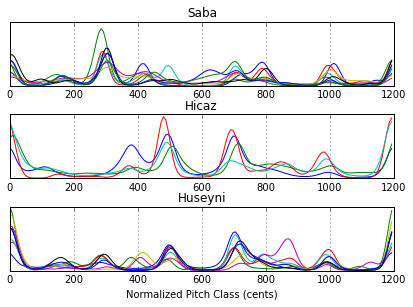

In [6]:
fig, ax = plt.subplots(3)
fig.tight_layout()
for ii, cur_mode in enumerate(modes):
    for pd in models[cur_mode]:
        ax[ii].plot(pd.bins, pd.vals, label=cur_mode)
   
    ax[ii].set_title(cur_mode)
    ax[ii].get_yaxis().set_visible(False)
    ax[ii].grid(True)
ax[ii].set_xlabel('Normalized Pitch Class (cents)')
    
plt.show()

From the distributions you can see some important differences in the peak locations, heights and shapes. In broder sense, these aspects of the distributions convey information about how the notes are being performed. For instance the 3rd degree of Hicaz makam (i.e. the third peak) does not coincide with the 3rd degrees of Saba and Hüseyni. Similarly the third degree of Saba makam is performed more frequent than the third of Hüseyni makam.

Using these distributions for comparison, we can find out the makam and/or tonic of another recording.

First let's load the pitch tracks for all the testing recordings. This is needed for all the estimation tasks below.

In [7]:
for rec in fold['test']:
    rec['pitch'] = np.loadtxt(rec['file'])
    

We start with tonic identification. Here, the assumption is given a recording with known makam and unknown tonic, the peaks of the makam distribution and the peaks of the distribution of the recording should coincide. We can check this by shifting the distribution of the template and finding the best shift according to a distance/similarity metric. The best shift will simply give us the tonic frequency.

In [8]:
reload(ChordiaEstimation)

# Tonic Identification
for rec in fold['test']:
    res = che.estimate(rec['pitch'], mode_names=['Hicaz', 'Huseyni', 'Saba'], mode_name=rec['mode'],
                       mode_dir=train_dir, est_tonic=True, est_mode=False,distance_method='bhat',
                       metric='pcd')[0]
    # evaluate
    e = evaluator.tonic_evaluate(rec['mbid'], res, rec['tonic'])
    
    print(rec['mbid'] + ", Anno: " + ("%.1f" % rec['tonic']) + " Hz, "
          "Est: " + ("%.1f" % res) + ' Hz: ' + str(e['tonic_eval']))

0db48ce4-f018-4d7d-b75e-66a64db72067, Anno: 151.1 Hz, Est: 606.3 Hz: True
03bcfc5c-4a34-490f-bdfa-1c8c2766bb50, Anno: 170.5 Hz, Est: 684.5 Hz: True
0b45417b-acb4-4f8a-b180-5ad45be889af, Anno: 328.3 Hz, Est: 655.5 Hz: True


So, for these 3 recordings, we identified all the tonics correctly! Note that this is a rather small and easy experiment (only 3 recordings, 3 classes etc.), so don't expect a "perfect" result for real datasets. 

Also, you might have noticed that the estimated tonic frequencies have octave errors. This is because of the octave we restrict ourselves when computing the PCDs. In this case by computing the "trend" of the pitch track, one can easily shift the estimated tonic to the correct octave. In practice, we cannot argue a definite tonic octace in many makam performances (esp. instrumental pieces), because all the instruments perform the same (heterophonic) melody in their own register; i.e. each performer has their own tonic frequency, all of which belong to the same pitch class.

Let's continue with makam recognition. If we know the tonic of the recording in advance, we can compare the distribution extracted from the recording with the makam distributions. The closest/most-similar distribution would point the estimated makam.

Tonic identification icin artik bundan daha iyi metodlar var. Hint muzikleri icin Gulati, makamlar icin Sercan. Bu sebeple histogram metodunun en kullanisli oldugu alan artik makam recognition.

In [9]:
# Makam Recognition
for rec in fold['test']:
    res = che.estimate(rec['pitch'], mode_names=['Hicaz', 'Huseyni', 'Saba'],  # first zero is to get the first rank
                       mode_dir=train_dir, est_tonic=False, est_mode=True,distance_method='bhat',  # second is to get the label
                       metric='pcd', ref_freq=rec['tonic'])[0]
    
    # evaluate
    e = evaluator.mode_evaluate(rec['mbid'], res, rec['mode'])
    
    print(rec['mbid'] + ", Anno: " + rec['mode'] + ", "
          "Est: " + res + ', ' + str(e['mode_eval']))

0db48ce4-f018-4d7d-b75e-66a64db72067, Anno: Hicaz, Est: Hicaz, True
03bcfc5c-4a34-490f-bdfa-1c8c2766bb50, Anno: Huseyni, Est: Huseyni, True
0b45417b-acb4-4f8a-b180-5ad45be889af, Anno: Saba, Est: Saba, True


Again, everything is correct! Apart from the fact that the dataset is small, these three makams are very distinct from each other as explained earlier. You should expect substantial confusion between similar makams (esp. transposed and compound types).

And finally, joint estimation of makam and tonic... Here we know neither the tonic nor the makam of the recording. In this case we basically check every (tonic-candidate, makam) combination. The closest (or the most similar) comparison provides us both the estimated tonic frequency and the makam.

In [10]:
# Joint Tonic and Makam Estimation
for rec in fold['test']:
    res_tonic, res_mode = che.estimate(rec['pitch'], mode_names=['Hicaz', 'Huseyni', 'Saba'], 
                       mode_dir=train_dir, est_tonic=True, est_mode=True,distance_method='bhat',
                       metric='pcd')[0]
    
    res_mode = res_mode
    res_tonic = res_tonic
    
    # evaluate
    e = evaluator.joint_evaluate(rec['mbid'], [res_tonic, rec['tonic']], [res_mode, rec['mode']])
    
    print(rec['mbid'] + ", Anno: " + rec['mode'] + ", "
              "Est: " + res_mode + ', ' + str(e['mode_eval']))
    print(" " * len(rec['mbid'] + ", ") + "Anno: " + ("%.1f" % rec['tonic']) + " Hz, "
              "Est: " + ("%.1f" % res_tonic) + ' Hz: ' + str(e['tonic_eval']))

0db48ce4-f018-4d7d-b75e-66a64db72067, Anno: Hicaz, Est: Hicaz, True
                                      Anno: 151.1 Hz, Est: 606.3 Hz: True
03bcfc5c-4a34-490f-bdfa-1c8c2766bb50, Anno: Huseyni, Est: Huseyni, True
                                      Anno: 170.5 Hz, Est: 684.5 Hz: True
0b45417b-acb4-4f8a-b180-5ad45be889af, Anno: Saba, Est: Saba, True
                                      Anno: 328.3 Hz, Est: 655.5 Hz: True


Again a perfect result! Note that in a meaningful dataset, this last step will not be so accurate as many makams tend to differ from each other with the location of a single interval, the relative strength (how much they are played compared to others) of some intervals etc. 

Buraya diger dezavantajlari yaz,